# Problem 7: Allometric scaling and pharmacokinetics

The study of pharmacokinetics in medicine seeks the ability to determine the clearance rate $C$ at which a human body removes a drug. 
This is valuable for determining the proper drug to administer a patient, and is particularly crucial for pediatric medicine where there are large ranges of body mass $M$. 

Over decades (and indeed [centuries](https://en.wikipedia.org/wiki/Square%E2%80%93cube_law)) of empirical and theory-driven studies, researchers have determined that power-laws can fit this data,

$ C = k M^\alpha $

where $k$ and $\alpha$ are parameters that depend on the drug.
The value of $\alpha$ has mechanistic meaning, and is typically $\alpha \in (0.6,1.0)$, but many clinical settings use $\alpha=0.75$.
See [Calvier et al, "Allometric Scaling of Clearance in Paediatric Patients" Clinical Pharmacokinetics 2017](https://link.springer.com/article/10.1007/s40262-016-0436-x) and [Valkengoed et al., "All You Need to Know About Allometric Scaling: An Integrative Review on the Theoretical Basis, Empirical Evidence, and Application in Human Pharmacology", Clinical Pharmakokinetics 2025](https://link.springer.com/article/10.1007/s40262-024-01444-6).

The following generates a synthetic dataset of size $N_{\textrm{obs}}$ for $C$ and $M$, assuming a ground truth of $\alpha_{\textrm{GT}}$ and normal random noise with $\sigma$.

Note that the patients sample has uniform random masses. 


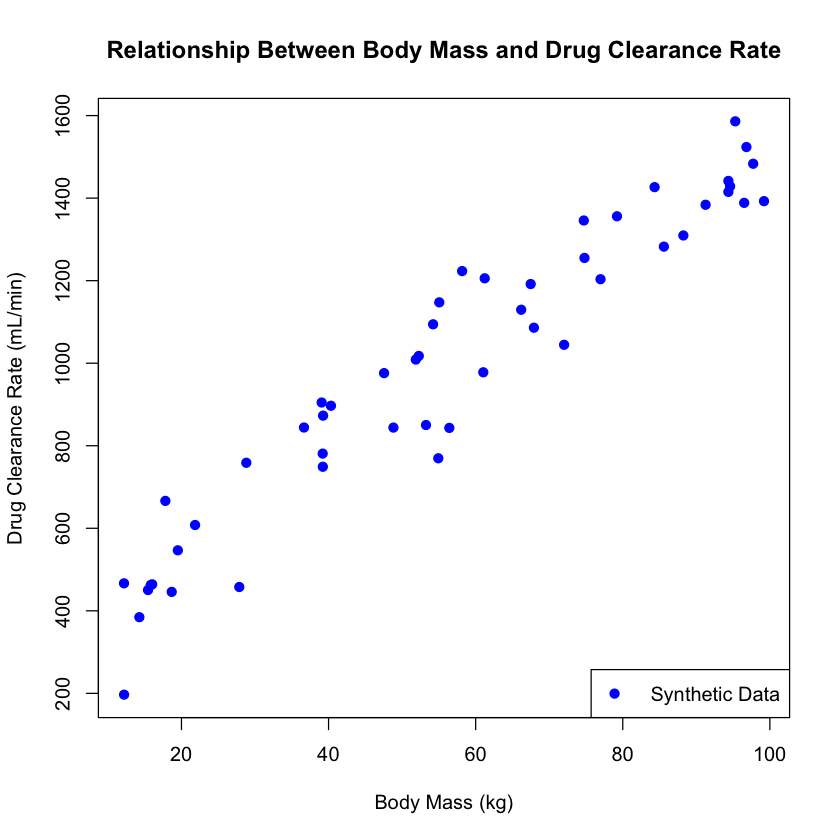

In [1]:
# Set seed for reproducibility
# set.seed(123)

# Define parameters
Nobs <- 50
M_min <- 12  # minimum body mass in kg
M_max <- 100 # maximum body mass in kg
alpha_gt <- 0.68
C_min <- 500  # minimum clearance rate in mL/min
C_max <- 1500 # maximum clearance rate in mL/min
sigma <- 100  # standard deviation for the noise (adjust as needed)

# Generate body mass values (uniform distribution)
M <- runif(Nobs, min = M_min, max = M_max)

# Calculate the value of k that will scale clearance rates to the desired range
max_M_alpha <- max(M)^alpha_gt
k_gt <- C_max / max_M_alpha

# Calculate theoretical clearance rates
C_theoretical <- k_gt * M^alpha_gt

# Add noise to the clearance rates
noise <- rnorm(Nobs, mean = 0, sd = sigma)
C_observed <- C_theoretical + noise

# Create a data frame
patient_data <- data.frame(
  PatientID = 1:Nobs,
  BodyMass = M,
  ClearanceRate_Theoretical = C_theoretical,
  ClearanceRate_Observed = C_observed
)

# Print summary statistics
# summary(patient_data)

# Plot the data
plot(patient_data$BodyMass, patient_data$ClearanceRate_Observed,
     xlab = "Body Mass (kg)",
     ylab = "Drug Clearance Rate (mL/min)",
     main = "Relationship Between Body Mass and Drug Clearance Rate",
     pch = 19,
     col = "blue")

# # Add a smooth curve of the theoretical relationship
# curve(k * x^alpha, from = M_min, to = M_max, add = TRUE, col = "red", lwd = 2)

# Add a legend
legend("bottomright", 
       legend = c("Synthetic Data"),
       col = c("blue"),
       pch = c(19, NA),
       lty = c(NA, 1),
       lwd = c(NA, 2))


## Question i

Transform the equation by taking the log. 
Your new equation should be a relationship between $lC = log(x)$ and $log(M)$, and be linear function of $k_1$ and $\alpha$. 

Take the log of the data.
Write code to perform linear regression to estimate $\alpha$.
Call this $\tilde{\alpha}$.


In [ ]:

# Take logs of the data
log_M <- log(M)
log_C <- log(C_observed)

# Perform linear regression on the log-transformed data
log_model <- lm(log_C ~ log_M)
alpha_estimated <- coef(log_model)[2]  # Slope corresponds to alpha

# Print results
cat("Ground truth alpha:", alpha_gt, "\n")
cat("Estimated alpha from log-linear regression:", alpha_estimated, "\n")
cat("Absolute error:", abs(alpha_estimated - alpha_gt), "\n")



Perform a sweep where you vary $\sigma$ and generate a new synthetic dataset.
For each $\sigma$, compute $|\tilde{\alpha} - \alpha_{\textrm{GT}}|$, the true error.
Plot the true error versus $\sigma$. 


In [ ]:
# Perform sweep over different noise levels
sigma_values <- seq(1, 100, by = 1)
error_values_log <- numeric(length(sigma_values))

for (i in 1:length(sigma_values)) {
  current_sigma <- sigma_values[i]
  
  # Generate new noise and observed clearance
  noise <- rnorm(Nobs, mean = 0, sd = current_sigma)
  C_observed <- C_theoretical + noise
  
  # Some noise values might make C_observed negative, which would make log undefined
  # Handle this by using only positive values
  valid_indices <- C_observed > 0
  
  if (sum(valid_indices) < 0.9 * Nobs) {
    # If too many negative values, skip this sigma
    error_values_log[i] <- NA
    next
  }
  
  # Take logs of valid data
  log_M_valid <- log_M[valid_indices]
  log_C_valid <- log(C_observed[valid_indices])
  
  # Fit log-linear model
  log_model <- lm(log_C_valid ~ log_M_valid)
  alpha_estimated <- coef(log_model)[2]
  
  # Calculate error
  error_values_log[i] <- abs(alpha_estimated - alpha_gt)
}

# Plot error vs sigma
plot(sigma_values, error_values_log, 
     type = "p", 
     xlab = "Noise Level (sigma)", 
     ylab = "Absolute Error in Alpha Estimate",
     main = "Error in Log-Linear Regression vs. Noise Level",
     pch = 19,
     col = "blue")


## Question ii
Now, let's perform a nonlinear fit using R's built-in `nls` function.
Do not transform the data. 

In [ ]:
# Create data frame for nls
data <- data.frame(M = M, C = C_observed)

# Fit nonlinear model
# Start with reasonable initial values for parameters
nls_model <- nls(C ~ k * M^alpha, data = data, 
                start = list(k = 100, alpha = 0.7))

# Get estimated parameters
params <- coef(nls_model)
k_estimated <- params["k"]
alpha_estimated <- params["alpha"]

# Print results
cat("True alpha:", alpha_gt, "\n")
cat("Estimated alpha from nonlinear regression:", alpha_estimated, "\n")
cat("Absolute error:", abs(alpha_estimated - alpha_gt), "\n")

Perform the same sweep as above, but now with `nls`. 
Make the same plot of $|\tilde{\alpha} - \alpha_{\textrm{GT}}|$, the true error.


We expect the true error to be smaller. Is it? By how much? For all values of $N_{\textrm{obs}}$?


## Question iii

In the above, the synthetic data was provided for a sample of patients with uniformly-distributed masses. 

Informal question:
What is the most realisitic distribution of masses for a patient sample? 
For adult data? For pediatrics (children)?

Formal question:
Implement another distribution of patient masses, and repeat both log-transformed linear fit and non-linear fit.

* What distribution gives the largest discrepancy between the two methods? 
* What distribution gives the smallest discrepancy between the two methods?


In [ ]:
# CODE HERE